## Generating expert trajectories

### Environment Setup

Custom 2-agent grid world using Gymnasium.

*Features*:

Grid size: 3x3

A1 starts at (0,0), A2 starts at (0,2).

Goals: A1 reach row 2, A2 reach column 0

Actions: [UP, DOWN, LEFT, RIGHT] (4 actions per agent).

Observations: Positions of both agents.

Rewards:

A1:   
|   |   |   |       
| - | - | - |       
| 1 | 4 | 7 |       
| 2 | 5 | 8 |      
| 3 | 6 | 9 |

A2:   
|    |    |    |       
| -- | -- | -- |       
| -1 | -4 | -7 |       
| -2 | -5 | -8 |      
| -3 | -6 | -9 |

In [32]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

grid_size = 3
max_steps = 100000

class GridGame1(gym.Env):
    metadata = {'render_modes': ['human'], 'render_fps': 4}

    def __init__(self):
        self.grid_size = grid_size
        self.n_agents = 2
        self.max_steps = max_steps

        # Updated start positions
        self.init_positions = [(0, 0), (0, 2)]  # A1 at (0,0), A2 at (0,2)

        # Goals
        self.goal_row_a1 = 2  # A1 needs to reach row 2
        self.goal_col_a2 = 0  # A2 needs to reach column 0

        # Action space: 4 actions per agent
        self.action_space = spaces.MultiDiscrete([4, 4])

        # Observation space: positions of both agents
        self.observation_space = spaces.Dict({
            "agent1": spaces.Box(0, self.grid_size - 1, shape=(2,), dtype=int),
            "agent2": spaces.Box(0, self.grid_size - 1, shape=(2,), dtype=int)
        })

        # Reset environment
        self.reset()

    def reset(self):
        self.agent1_pos, self.agent2_pos = self.init_positions
        self.steps = 0
        return self._get_obs(), {}

    def _get_obs(self):
        return {
            "agent1": np.array(self.agent1_pos),
            "agent2": np.array(self.agent2_pos)
        }

    def step(self, actions):
        self.steps += 1

        # Move agents
        new_pos1 = self._move(self.agent1_pos, actions[0])
        new_pos2 = self._move(self.agent2_pos, actions[1])

        # Check for collision
        if new_pos1 == new_pos2:
            new_pos1 = self.agent1_pos
            new_pos2 = self.agent2_pos
            reward1 = reward2 = -1  # penalty for collision
            done = False
        else:
            reward1 = self._compute_reward_agent1(new_pos1)
            reward2 = self._compute_reward_agent2(new_pos2)

            self.agent1_pos = new_pos1
            self.agent2_pos = new_pos2

            done_a1 = self.agent1_pos[0] == self.goal_row_a1
            done_a2 = self.agent2_pos[1] == self.goal_col_a2
            done = done_a1 or done_a2

        # Force episode end after max_steps
        done = done or self.steps >= self.max_steps

        return self._get_obs(), (reward1, reward2), done, {}, {}

    def _compute_reward_agent1(self, pos):
        x, y = pos
        # A1 reward matrix values (flipped row-wise)
        reward_map = [
            [1, 4, 7],
            [2, 5, 8],
            [3, 6, 9]
        ]
        return reward_map[x][y]

    def _compute_reward_agent2(self, pos):
        x, y = pos
        # A2 reward matrix values (flipped and negative)
        reward_map = [
            [-1, -4, -7],
            [-2, -5, -8],
            [-3, -6, -9]
        ]
        return reward_map[x][y]

    def _move(self, pos, action):
        x, y = pos
        if action == 0:  # UP
            x = max(0, x - 1)
        elif action == 1:  # DOWN
            x = min(self.grid_size - 1, x + 1)
        elif action == 2:  # LEFT
            y = max(0, y - 1)
        elif action == 3:  # RIGHT
            y = min(self.grid_size - 1, y + 1)
        return (x, y)

    def render(self):
        grid = np.full((3, 3), '·', dtype='<U3')

        # Mark goals
        for col in range(self.grid_size):
            grid[self.goal_row_a1, col] = 'G1'
        for row in range(self.grid_size):
            if grid[row, self.goal_col_a2] == 'G1':
                grid[row, self.goal_col_a2] = 'G1/2'
            else:
                grid[row, self.goal_col_a2] = 'G2'

        # Mark agents
        ax1, ay1 = self.agent1_pos
        ax2, ay2 = self.agent2_pos
        if (ax1, ay1) == (ax2, ay2):
            grid[ax1, ay1] = 'A*'
        else:
            grid[ax1, ay1] = 'A1'
            grid[ax2, ay2] = 'A2'

        print("Current State:")
        for row in grid:
            print(" ".join(f"{cell:^5}" for cell in row))
        print()


In [33]:
env = GridGame1()
env.render()

Current State:
 A1     ·    A2  
 G2     ·     ·  
 G1/   G1    G1  



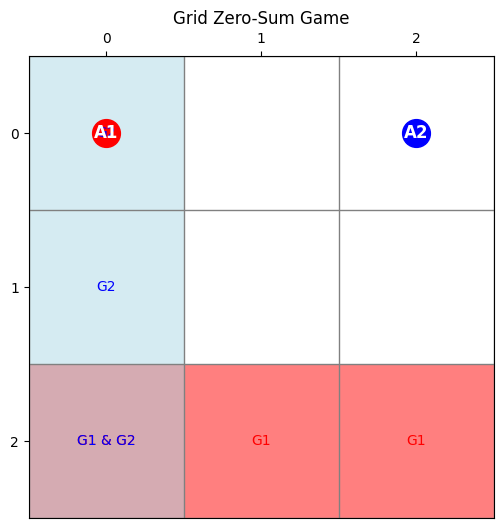

In [48]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_env_state(env):
    fig, ax = plt.subplots(figsize=(6, 6))

    # 1) Draw grid lines
    for x in range(env.grid_size + 1):
        ax.axvline(x, color='gray', linestyle='-', linewidth=1)
    for y in range(env.grid_size + 1):
        ax.axhline(y, color='gray', linestyle='-', linewidth=1)

    # 2) Set axis limits and ticks
    ax.set_xlim(0, env.grid_size)
    ax.set_ylim(0, env.grid_size)
    ax.set_xticks([i + 0.5 for i in range(env.grid_size)])
    ax.set_yticks([i + 0.5 for i in range(env.grid_size)])
    ax.set_xticklabels([str(i) for i in range(env.grid_size)])
    ax.set_yticklabels([str(i) for i in range(env.grid_size)])

    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.invert_yaxis()
    ax.set_title("Grid Zero-Sum Game")

    # Helper for plotting cells
    def cell_coords(row, col):
        return (col, row)

    def center_coords(row, col):
        return (col + 0.5, row + 0.5)

    # 3) Highlight A1's goal row (row 2)
    for col in range(env.grid_size):
        current_label = "G1"
        if col == env.goal_col_a2 and 0 < env.grid_size:
            current_label = "G1 & G2"
        ax.add_patch(patches.Rectangle(cell_coords(env.goal_row_a1, col), 1, 1, facecolor='red', alpha=0.5))
        ax.text(*center_coords(env.goal_row_a1, col), current_label, ha='center', va='center', fontsize=10, color='red')

    # 4) Highlight A2's goal column (col 0)
    for row in range(env.grid_size):
        current_label = "G2"
        # If G1 already in the cell, merge label
        if row == env.goal_row_a1 and 0 < env.grid_size:
            current_label = "G1 & G2"
        ax.add_patch(patches.Rectangle(cell_coords(row, env.goal_col_a2), 1, 1, facecolor='lightblue', alpha=0.5))
        ax.text(*center_coords(row, env.goal_col_a2), current_label, ha='center', va='center', fontsize=10, color='blue')

    # 5) Plot agents
    a1_row, a1_col = env.agent1_pos
    a2_row, a2_col = env.agent2_pos

    if (a1_row, a1_col) == (a2_row, a2_col):
        ax.plot(*center_coords(a1_row, a1_col), 'purple', marker='o', markersize=20)
        ax.text(*center_coords(a1_row, a1_col), "A1&A2", fontsize=10, ha='center', va='center', color='white', fontweight='bold')
    else:
        ax.plot(*center_coords(a1_row, a1_col), 'ro', markersize=20)
        ax.text(*center_coords(a1_row, a1_col), "A1", fontsize=12, ha='center', va='center', color='white', fontweight='bold')

        ax.plot(*center_coords(a2_row, a2_col), 'bo', markersize=20)
        ax.text(*center_coords(a2_row, a2_col), "A2", fontsize=12, ha='center', va='center', color='white', fontweight='bold')

    plt.show()

# Test with updated env
env = GridGame1()
env.reset()
plot_env_state(env)

### Nash Q-Learning

In [35]:
import numpy as np
from nashpy import Game
import matplotlib.pyplot as plt

class NashQLearner:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.5, min_epsilon=0.01, decay_rate=0.0005):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.decay_rate = decay_rate
        self.epsilon_history = []

        self.grid_size = env.grid_size
        self.Q1 = np.zeros((self.grid_size, self.grid_size, self.grid_size, self.grid_size, 4, 4))
        self.Q2 = np.zeros((self.grid_size, self.grid_size, self.grid_size, self.grid_size, 4, 4))

    def decay_epsilon(self, episode):
        self.epsilon = max(self.min_epsilon, self.epsilon * np.exp(-self.decay_rate * episode))
        self.epsilon_history.append(self.epsilon)

    def get_action(self, state, explore=True):
        s = self._state_to_index(state)
    
        game = Game(self.Q1[s], self.Q2[s])
        equilibria = list(game.support_enumeration())
    
        if len(equilibria) > 1:
            print(f"\n Multiple equilibria found at state {s}:")
            print_equilibria(self.Q1[s], self.Q2[s])
    
        if not equilibria or (explore and np.random.rand() < self.epsilon):
            return np.random.randint(0, 4), np.random.randint(0, 4)
    
        pi1, pi2 = equilibria[0]
        a1 = np.random.choice(4, p=pi1)
        a2 = np.random.choice(4, p=pi2)
        return a1, a2

    def update(self, state, actions, rewards, next_state):
        s = self._state_to_index(state)
        s_next = self._state_to_index(next_state)
        a1, a2 = actions
        r1, r2 = rewards

        game_next = Game(self.Q1[s_next], self.Q2[s_next])
        equilibria_next = list(game_next.support_enumeration())

        if not equilibria_next:
            nash_q1 = 0
            nash_q2 = 0
        else:
            pi1_next, pi2_next = equilibria_next[0]  # Again, just take the first
            nash_q1 = np.sum(np.outer(pi1_next, pi2_next) * self.Q1[s_next])
            nash_q2 = np.sum(np.outer(pi1_next, pi2_next) * self.Q2[s_next])

        self.Q1[s][a1][a2] += self.alpha * (r1 + self.gamma * nash_q1 - self.Q1[s][a1][a2])
        self.Q2[s][a1][a2] += self.alpha * (r2 + self.gamma * nash_q2 - self.Q2[s][a1][a2])

    def _state_to_index(self, state):
        return (
            state["agent1"][0], state["agent1"][1],
            state["agent2"][0], state["agent2"][1]
        )

    def plot_learning_curve(self, episode_rewards):
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(len(episode_rewards)), [r[0] for r in episode_rewards], label="Agent 1")
        plt.plot(np.arange(len(episode_rewards)), [r[1] for r in episode_rewards], label="Agent 2")
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title("Learning Curve")
        plt.legend()
        plt.grid(True)
        plt.show()

##### Training Loop

c:\Users\lents\anaconda3\lib\site-packages\nashpy\algorithms\support_enumeration.py:260: RuntimeWarning: 
An even number of (16) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)



 Multiple equilibria found at state (0, 0, 0, 2):
16 Nash equilibria found:
Equilibrium 1:
  Agent 1 strategy: [1. 0. 0. 0.]
  Agent 2 strategy: [1. 0. 0. 0.]

Equilibrium 2:
  Agent 1 strategy: [1. 0. 0. 0.]
  Agent 2 strategy: [0. 1. 0. 0.]

Equilibrium 3:
  Agent 1 strategy: [1. 0. 0. 0.]
  Agent 2 strategy: [0. 0. 1. 0.]

Equilibrium 4:
  Agent 1 strategy: [1. 0. 0. 0.]
  Agent 2 strategy: [0. 0. 0. 1.]

Equilibrium 5:
  Agent 1 strategy: [0. 1. 0. 0.]
  Agent 2 strategy: [1. 0. 0. 0.]

Equilibrium 6:
  Agent 1 strategy: [0. 1. 0. 0.]
  Agent 2 strategy: [0. 1. 0. 0.]

Equilibrium 7:
  Agent 1 strategy: [0. 1. 0. 0.]
  Agent 2 strategy: [0. 0. 1. 0.]

Equilibrium 8:
  Agent 1 strategy: [0. 1. 0. 0.]
  Agent 2 strategy: [0. 0. 0. 1.]

Equilibrium 9:
  Agent 1 strategy: [0. 0. 1. 0.]
  Agent 2 strategy: [1. 0. 0. 0.]

Equilibrium 10:
  Agent 1 strategy: [0. 0. 1. 0.]
  Agent 2 strategy: [0. 1. 0. 0.]

Equilibrium 11:
  Agent 1 strategy: [0. 0. 1. 0.]
  Agent 2 strategy: [0. 0. 1. 0.

c:\Users\lents\anaconda3\lib\site-packages\nashpy\algorithms\support_enumeration.py:260: RuntimeWarning: 
An even number of (12) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)
c:\Users\lents\anaconda3\lib\site-packages\nashpy\algorithms\support_enumeration.py:260: RuntimeWarning: 
An even number of (8) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)



 Multiple equilibria found at state (0, 1, 0, 2):
8 Nash equilibria found:
Equilibrium 1:
  Agent 1 strategy: [1. 0. 0. 0.]
  Agent 2 strategy: [0. 0. 1. 0.]

Equilibrium 2:
  Agent 1 strategy: [1. 0. 0. 0.]
  Agent 2 strategy: [0. 0. 0. 1.]

Equilibrium 3:
  Agent 1 strategy: [0. 1. 0. 0.]
  Agent 2 strategy: [0. 0. 1. 0.]

Equilibrium 4:
  Agent 1 strategy: [0. 1. 0. 0.]
  Agent 2 strategy: [0. 0. 0. 1.]

Equilibrium 5:
  Agent 1 strategy: [0. 0. 1. 0.]
  Agent 2 strategy: [0. 0. 1. 0.]

Equilibrium 6:
  Agent 1 strategy: [0. 0. 1. 0.]
  Agent 2 strategy: [0. 0. 0. 1.]

Equilibrium 7:
  Agent 1 strategy: [0. 0. 0. 1.]
  Agent 2 strategy: [0. 0. 1. 0.]

Equilibrium 8:
  Agent 1 strategy: [0. 0. 0. 1.]
  Agent 2 strategy: [0. 0. 0. 1.]


 Multiple equilibria found at state (0, 0, 0, 2):
12 Nash equilibria found:
Equilibrium 1:
  Agent 1 strategy: [1. 0. 0. 0.]
  Agent 2 strategy: [1. 0. 0. 0.]

Equilibrium 2:
  Agent 1 strategy: [1. 0. 0. 0.]
  Agent 2 strategy: [0. 1. 0. 0.]

Equilib

c:\Users\lents\anaconda3\lib\site-packages\nashpy\algorithms\support_enumeration.py:260: RuntimeWarning: 
An even number of (4) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)



 Multiple equilibria found at state (0, 1, 0, 2):
4 Nash equilibria found:
Equilibrium 1:
  Agent 1 strategy: [1. 0. 0. 0.]
  Agent 2 strategy: [0. 0. 1. 0.]

Equilibrium 2:
  Agent 1 strategy: [0. 1. 0. 0.]
  Agent 2 strategy: [0. 0. 1. 0.]

Equilibrium 3:
  Agent 1 strategy: [0. 0. 1. 0.]
  Agent 2 strategy: [0. 0. 1. 0.]

Equilibrium 4:
  Agent 1 strategy: [0. 0. 0. 1.]
  Agent 2 strategy: [0. 0. 1. 0.]


 Multiple equilibria found at state (0, 1, 0, 2):
3 Nash equilibria found:
Equilibrium 1:
  Agent 1 strategy: [0. 1. 0. 0.]
  Agent 2 strategy: [0. 0. 1. 0.]

Equilibrium 2:
  Agent 1 strategy: [0. 0. 1. 0.]
  Agent 2 strategy: [0. 0. 1. 0.]

Equilibrium 3:
  Agent 1 strategy: [0. 0. 0. 1.]
  Agent 2 strategy: [0. 0. 1. 0.]


 Multiple equilibria found at state (1, 1, 0, 1):
16 Nash equilibria found:
Equilibrium 1:
  Agent 1 strategy: [1. 0. 0. 0.]
  Agent 2 strategy: [1. 0. 0. 0.]

Equilibrium 2:
  Agent 1 strategy: [1. 0. 0. 0.]
  Agent 2 strategy: [0. 1. 0. 0.]

Equilibrium 3:


c:\Users\lents\anaconda3\lib\site-packages\nashpy\algorithms\support_enumeration.py:260: RuntimeWarning: 
An even number of (0) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)



 Multiple equilibria found at state (0, 0, 1, 2):
16 Nash equilibria found:
Equilibrium 1:
  Agent 1 strategy: [1. 0. 0. 0.]
  Agent 2 strategy: [1. 0. 0. 0.]

Equilibrium 2:
  Agent 1 strategy: [1. 0. 0. 0.]
  Agent 2 strategy: [0. 1. 0. 0.]

Equilibrium 3:
  Agent 1 strategy: [1. 0. 0. 0.]
  Agent 2 strategy: [0. 0. 1. 0.]

Equilibrium 4:
  Agent 1 strategy: [1. 0. 0. 0.]
  Agent 2 strategy: [0. 0. 0. 1.]

Equilibrium 5:
  Agent 1 strategy: [0. 1. 0. 0.]
  Agent 2 strategy: [1. 0. 0. 0.]

Equilibrium 6:
  Agent 1 strategy: [0. 1. 0. 0.]
  Agent 2 strategy: [0. 1. 0. 0.]

Equilibrium 7:
  Agent 1 strategy: [0. 1. 0. 0.]
  Agent 2 strategy: [0. 0. 1. 0.]

Equilibrium 8:
  Agent 1 strategy: [0. 1. 0. 0.]
  Agent 2 strategy: [0. 0. 0. 1.]

Equilibrium 9:
  Agent 1 strategy: [0. 0. 1. 0.]
  Agent 2 strategy: [1. 0. 0. 0.]

Equilibrium 10:
  Agent 1 strategy: [0. 0. 1. 0.]
  Agent 2 strategy: [0. 1. 0. 0.]

Equilibrium 11:
  Agent 1 strategy: [0. 0. 1. 0.]
  Agent 2 strategy: [0. 0. 1. 0.

c:\Users\lents\anaconda3\lib\site-packages\nashpy\algorithms\support_enumeration.py:260: RuntimeWarning: 
An even number of (2) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)



 Multiple equilibria found at state (0, 0, 2, 2):
2 Nash equilibria found:
Equilibrium 1:
  Agent 1 strategy: [0.42024614 0.47277691 0.10697695 0.        ]
  Agent 2 strategy: [0.33333333 0.33247686 0.33418981 0.        ]

Equilibrium 2:
  Agent 1 strategy: [0.42024614 0.47277691 0.10697695 0.        ]
  Agent 2 strategy: [0.33333333 0.         0.33418981 0.33247686]


 Multiple equilibria found at state (1, 0, 2, 2):
12 Nash equilibria found:
Equilibrium 1:
  Agent 1 strategy: [1. 0. 0. 0.]
  Agent 2 strategy: [0. 1. 0. 0.]

Equilibrium 2:
  Agent 1 strategy: [1. 0. 0. 0.]
  Agent 2 strategy: [0. 0. 1. 0.]

Equilibrium 3:
  Agent 1 strategy: [1. 0. 0. 0.]
  Agent 2 strategy: [0. 0. 0. 1.]

Equilibrium 4:
  Agent 1 strategy: [0. 1. 0. 0.]
  Agent 2 strategy: [0. 1. 0. 0.]

Equilibrium 5:
  Agent 1 strategy: [0. 1. 0. 0.]
  Agent 2 strategy: [0. 0. 1. 0.]

Equilibrium 6:
  Agent 1 strategy: [0. 1. 0. 0.]
  Agent 2 strategy: [0. 0. 0. 1.]

Equilibrium 7:
  Agent 1 strategy: [0. 0. 1. 0.

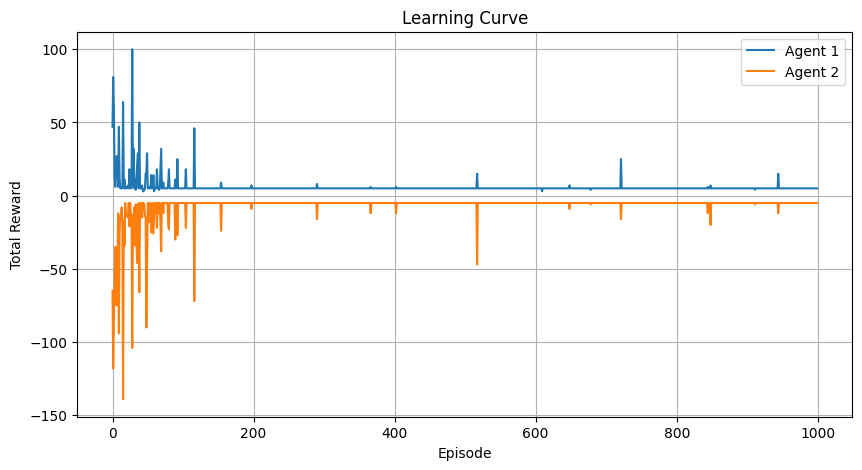

In [36]:
env = GridGame1()
agent = NashQLearner(env, alpha=0.1, gamma=0.99, epsilon=0.5)

all_episode_rewards = []
epsilon_decay = []
n_episodes = 1000

for episode in range(n_episodes):
    state, _ = env.reset()
    done = False
    total_reward = [0, 0]

    while not done:
        actions = agent.get_action(state)
        next_state, rewards, terminated, truncated, _ = env.step(actions)
        done = terminated or truncated

        agent.update(state, actions, rewards, next_state)
        state = next_state

        total_reward[0] += rewards[0]
        total_reward[1] += rewards[1]

    all_episode_rewards.append(total_reward)
    agent.decay_epsilon(episode)
    epsilon_decay.append(agent.epsilon)

    if episode % 10 == 0:
        avg_rewards = np.mean(all_episode_rewards[-10:], axis=0)
        print(f"Episode {episode:03d} | Avg Reward: A1: {avg_rewards[0]:.2f}, A2: {avg_rewards[1]:.2f}")

# Plot learning curve
agent.plot_learning_curve(all_episode_rewards)


In [37]:
from nashpy import Game

def print_equilibria(Q1_matrix, Q2_matrix):
    game = Game(Q1_matrix, Q2_matrix)
    equilibria = list(game.support_enumeration())

    if len(equilibria) == 0:
        print("No Nash equilibrium found.")
    elif len(equilibria) == 1:
        print("One Nash equilibrium found:")
    else:
        print(f"{len(equilibria)} Nash equilibria found:")

    for i, (pi1, pi2) in enumerate(equilibria):
        print(f"Equilibrium {i+1}:")
        print(f"  Agent 1 strategy: {pi1}")
        print(f"  Agent 2 strategy: {pi2}")
        print()


### Plotting

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_q_values(agent, agent_id=1, state=(1, 1, 1, 1)):
    q_table = agent.Q1[state] if agent_id == 1 else agent.Q2[state]

    plt.figure(figsize=(8, 6))
    sns.heatmap(q_table, annot=True, fmt=".1f", cmap="viridis")

    action_names = ["UP", "DOWN", "LEFT", "RIGHT"]
    plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=action_names)
    plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=action_names)

    plt.xlabel("Agent 2 Actions")
    plt.ylabel("Agent 1 Actions")
    plt.title(f"Q-Values for Agent {agent_id} in State {state}")
    plt.show()


def visualize_trajectory(agent, env):
    state, _ = env.reset()
    done = False
    trajectory1 = [state["agent1"]]
    trajectory2 = [state["agent2"]]

    while not done:
        actions = agent.get_action(state, explore=False)
        next_state, _, terminated, truncated, _ = env.step(actions)
        done = terminated or truncated
        trajectory1.append(next_state["agent1"])
        trajectory2.append(next_state["agent2"])
        state = next_state

    plt.figure(figsize=(8, 8))

    def convert_2darray_coords(pos):
        return (pos[1], 2 - pos[0])  # Flip row index for display

    # Plot agent trajectories
    plt.plot(*zip(*[convert_2darray_coords(p) for p in trajectory1]),
             marker='o', label="Agent 1", color='blue')
    plt.plot(*zip(*[convert_2darray_coords(p) for p in trajectory2]),
             marker='s', label="Agent 2", color='red')

    # Plot agent initial positions
    init1 = convert_2darray_coords(env.init_positions[0])
    init2 = convert_2darray_coords(env.init_positions[1])
    plt.text(*init1, "A1", fontsize=12, ha='center', va='center', color='blue', fontweight='bold')
    plt.text(*init2, "A2", fontsize=12, ha='center', va='center', color='red', fontweight='bold')

    # Axis config
    plt.xticks([0, 1, 2], ['0', '1', '2'])
    plt.yticks([0, 1, 2], ['2', '1', '0'])
    plt.grid(True)
    plt.xlim(-0.5, 2.5)
    plt.ylim(-0.5, 2.5)

    plt.gca().xaxis.set_ticks_position('top')
    plt.gca().xaxis.set_label_position('top')

    plt.legend()
    plt.title("Agents Trajectories")
    plt.show()


def plot_exploration_decay(epsilon_decay):
    plt.figure(figsize=(10, 5))
    plt.plot(np.arange(len(epsilon_decay)), epsilon_decay)
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.title("Exploration Rate Decay")
    plt.grid(True)
    plt.show()


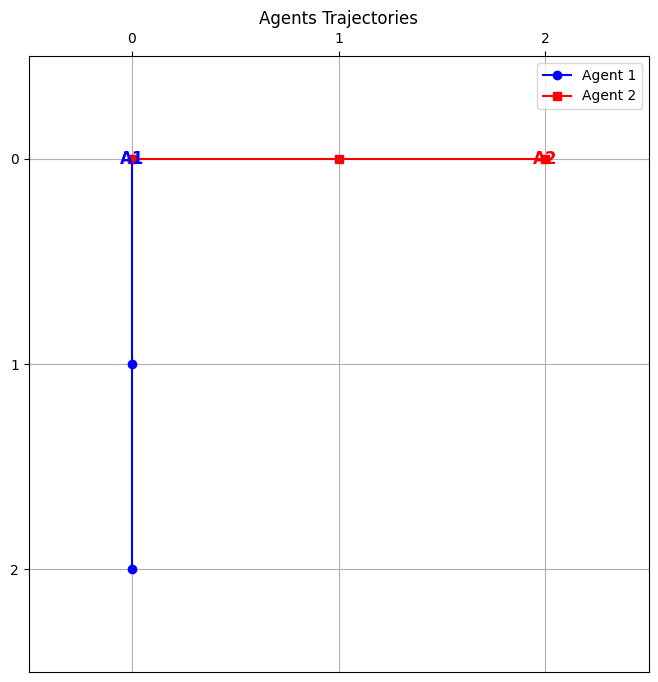

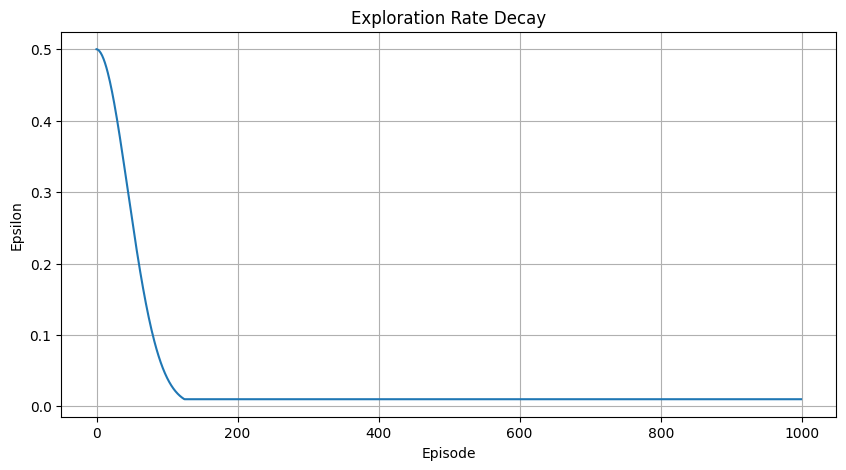

In [50]:
visualize_trajectory(agent, env)
plot_exploration_decay(epsilon_decay)

### Trajectories Sampling

In [45]:
def sample_expert_trajectories(agent, env, n_episodes=100):
    expert_trajectories = []

    for _ in range(n_episodes):
        episode = []
        obs, _ = env.reset()
        done = False

        while not done:
            actions = agent.get_action(obs, explore=False)
            next_obs, rewards, terminated, truncated, _ = env.step(actions)
            done = terminated or truncated

            step = {
                "obs": {
                    "agent1": obs["agent1"].copy(),
                    "agent2": obs["agent2"].copy()
                },
                "actions": actions,
                "next_obs": {
                    "agent1": next_obs["agent1"].copy(),
                    "agent2": next_obs["agent2"].copy()
                },
                "rewards": rewards,
                "done": done
            }

            episode.append(step)
            obs = next_obs

        expert_trajectories.append(episode)

    return expert_trajectories


In [46]:
def print_trajectories(trajectories, max_episodes=10):
    for ep_idx, episode in enumerate(trajectories[:max_episodes]):
        print(f"\n=== Trajectory {ep_idx + 1} ===")
        for t, step in enumerate(episode):
            obs1 = tuple(step["obs"]["agent1"])
            obs2 = tuple(step["obs"]["agent2"])
            a1, a2 = step["actions"]
            r1, r2 = step["rewards"]
            next_obs1 = tuple(step["next_obs"]["agent1"])
            next_obs2 = tuple(step["next_obs"]["agent2"])
            done = step["done"]

            print(f"Step {t:02d} | Obs: A1{obs1}, A2{obs2} | "
                  f"Actions: A1={a1}, A2={a2} | "
                  f"Rewards: A1={r1}, A2={r2} | "
                  f"Next: A1{next_obs1}, A2{next_obs2} | Done: {done}")


In [ ]:
# printing some trajectories -> they're all identical
trajectories = sample_expert_trajectories(agent, env, n_episodes=100)
print_trajectories(trajectories, max_episodes=10)


=== Trajectory 1 ===
Step 00 | Obs: A1(0, 0), A2(0, 2) | Actions: A1=1, A2=2 | Rewards: A1=2, A2=-4 | Next: A1(1, 0), A2(0, 1) | Done: {}
Step 01 | Obs: A1(1, 0), A2(0, 1) | Actions: A1=1, A2=2 | Rewards: A1=3, A2=-1 | Next: A1(2, 0), A2(0, 0) | Done: True

=== Trajectory 2 ===
Step 00 | Obs: A1(0, 0), A2(0, 2) | Actions: A1=1, A2=2 | Rewards: A1=2, A2=-4 | Next: A1(1, 0), A2(0, 1) | Done: {}
Step 01 | Obs: A1(1, 0), A2(0, 1) | Actions: A1=1, A2=2 | Rewards: A1=3, A2=-1 | Next: A1(2, 0), A2(0, 0) | Done: True

=== Trajectory 3 ===
Step 00 | Obs: A1(0, 0), A2(0, 2) | Actions: A1=1, A2=2 | Rewards: A1=2, A2=-4 | Next: A1(1, 0), A2(0, 1) | Done: {}
Step 01 | Obs: A1(1, 0), A2(0, 1) | Actions: A1=1, A2=2 | Rewards: A1=3, A2=-1 | Next: A1(2, 0), A2(0, 0) | Done: True

=== Trajectory 4 ===
Step 00 | Obs: A1(0, 0), A2(0, 2) | Actions: A1=1, A2=2 | Rewards: A1=2, A2=-4 | Next: A1(1, 0), A2(0, 1) | Done: {}
Step 01 | Obs: A1(1, 0), A2(0, 1) | Actions: A1=1, A2=2 | Rewards: A1=3, A2=-1 | Next: 